## 1. Подключим библиотеки, которые потребуются для загрузки и первичного анализа данных

In [5]:
import pandas as pd
from google.colab import files

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

%matplotlib inline
data_source = 'iris.data'
d = pd.read_table(data_source, delimiter=',', header=None,
names=['sepal_length','sepal_width',
'petal_length', 'petal_width','answer'])
# Содержит только первые четыре столбца (индексы 0, 1, 2 и 3)
dX = d.iloc[ : , 0:4 ]
# Сохраняет целевую переменную
dy = d['answer']
print(dX.head())
print(dy.head())

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: answer, dtype: object


## 2. Построение дерево классификаций

Для построения дерева классификации воспользуемся специальным классом sklearn.tree.DecisionTreeClassifier. Оценими точность модели методом hold-out. Следует обратить внимание, что если в методе ближайших соседей производилась оптимизация по одному параметру K – количеству ближайших соседей, то при создании модели  DecisionTreeClassifier необходимо указать два параметра: максимальную глубину дерева (max_depth) и количество признаков разделения дерева (max_features)

In [6]:
# Класс для построения классификатора на основе решения дерева (decision tree)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# Функция для вычисления точности классификатора,
# т.е. насколько правильно классификатор предсказал метки для тестовых данных.
from sklearn.metrics import accuracy_score

#Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = \
train_test_split(dX, dy, test_size=0.3, random_state=12)

# Обучение модели
# Создание экземпляра классификатора на основе дерева решений с параметрами
tree = DecisionTreeClassifier(max_depth=5,
random_state=21,
max_features=2)
tree.fit(X_train, y_train)
#Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.9777777777777777


## 3. Произведем оценку точности модели по методу cross validation, а также сделаем выводы об оптимальном значении параметра max_depth.

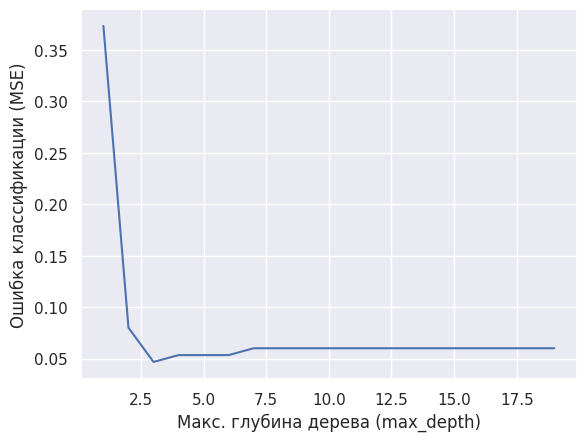

Оптимальные значения max_depth:  [3]


In [7]:
from sklearn.model_selection import cross_val_score
#Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения К
for d in d_list:
  tree = DecisionTreeClassifier(max_depth=d,
                            random_state=21,
                            max_features=2)
  scores = cross_val_score(tree, dX, dy, cv=10, scoring='accuracy')
  cv_scores.append(scores.mean())
# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]
# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
  if MSE[i] <= d_min:
      all_d_min.append(d_list[i])
# печатаем все К, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

## 4. Оптимальное значение параметра max_depth модели получено, но в модели присутствует еще один параметр max_features, который был установлен в значение 2 (не изменялся и не оптимизировался). Для проведения cross validation по всем параметрам воспользуемся классом GridSearchCV пакета sklearn.model_selection

In [8]:
# GridSearchCV — класс для нахождения оптимальных параметров для модели, перебирая все возможные комбинации в заданном диапазоне.
from sklearn.model_selection import GridSearchCV, cross_val_score
# Модуль, содержащий дерево решений
from sklearn import tree

# Создается классификатор дерева решений с фиксированными параметрами
# Но дальше подбор параметров будет проводиться через GridSearchCV
dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

# Это словарь, который задает диапазоны значений для двух гиперпараметров
tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
# GridSearchCV — выполняет перебор всех возможных комбинаций параметров, указанных в tree_params, и оценивает модель с каждым сочетанием через 10-кратную кросс-валидацию
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
# Обучение модели с использованием кросс-валидации
tree_grid.fit(dX, dy)

print('\n')
# Выводит параметры, которые дали наилучший результат при кросс-валидации
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
# выводит наилучший результат (среднюю точность) кросс-валидации для оптимальных параметров.
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

# Генерируем графическое представление дерева
tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file='iris_tree.dot',
                     filled=True, rounded=True)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 2, 'max_features': 3}
Лучшие баллы cross validation:  0.9533333333333334


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


## 5. Оптимальные параметры определены, можно обучить модель и использовать ее для классификации


In [9]:
# Построим области решения для оптимального дерева
# max_features = 2, max_depth = 3
dtc = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
dtc.fit(dX, dy)
res = dtc.predict(pd.DataFrame([[5.1, 3.5, 1.4, 0.2]], columns=dX.columns))
print(res)


['Iris-setosa']


## 6. Построение визуализации процесса логической классификации – покажем решающие границы модели классификации

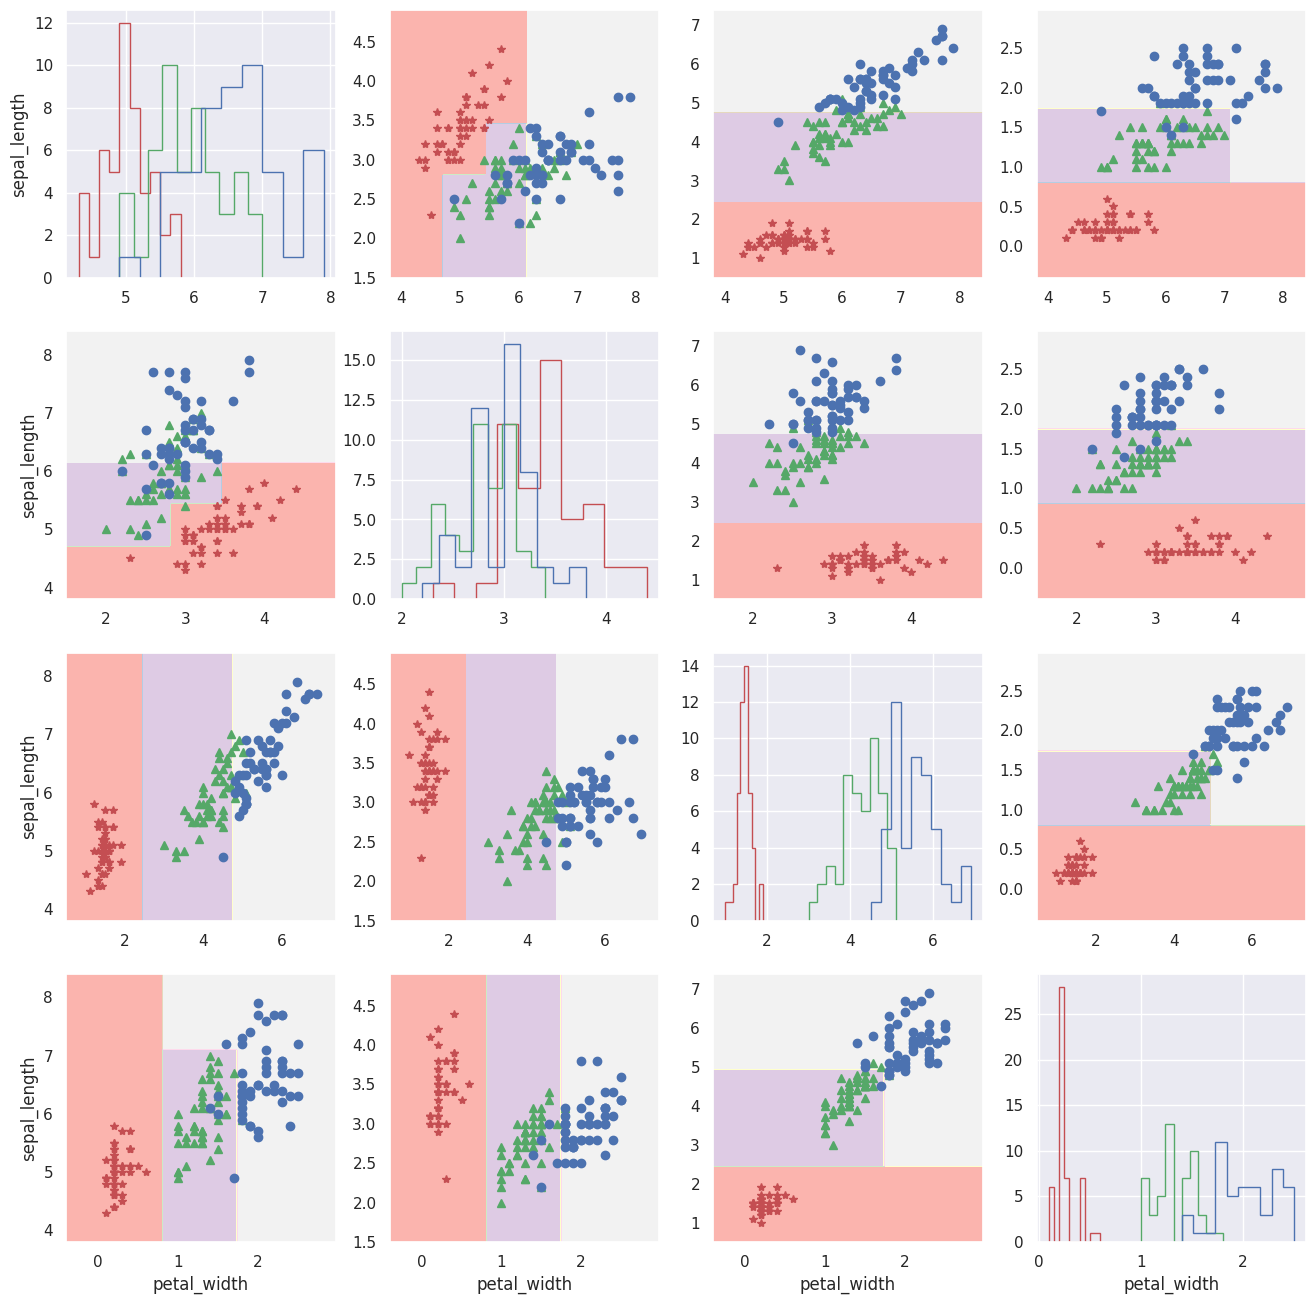

In [10]:
# plot_markers — список маркеров для различных классов
plot_markers = ['r*', 'g^', 'bo']
# answers — уникальные значения целевой переменной dy
answers = dy.unique()

# Создаем подграфики для каждой пары признаков
# Создается сетка подграфиков 4x4, где каждый подграфик будет представлять собой график для пары признаков.
f, places = plt.subplots(4, 4, figsize=(16, 16))
# Определяются минимальные и максимальные значения признаков с небольшим запасом, чтобы графики не были сжаты.
fmin = dX.min() - 0.5
fmax = dX.max() + 0.5
# Шаг сетки для построения решающих границ модели.
plot_step = 0.02

# Перебираем все возможные пары признаков (всего 4 признака), и для каждой пары создаем подграфик.
for i in range(0, 4):
    for j in range(0, 4):

        # Строим решающие границы
        # Избегаем диагональных подграфиков, где переменные будут одинаковыми.
        if i != j:
          # Генерируем сетку точек для двух признаков, по которым мы хотим построить решающие границы.
            xx, yy = np.meshgrid(
                np.arange(fmin.iloc[i], fmax.iloc[i], plot_step),
                np.arange(fmin.iloc[j], fmax.iloc[j], plot_step)
            )
            # Создаем модель дерева решений с ограничением на максимальную глубину (max_depth=3) и ограничением на количество признаков для использования (max_features=2).
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            #  Обучаем дерево решений на данных, содержащих только два выбранных признака
            model.fit(dX.iloc[:, [i, j]], dy)

            # Создание DataFrame для предсказаний модели на сетке xx, yy с именами столбцов.
            # Создаем DataFrame для точек сетки, которые будут использоваться для предсказания.
            grid_points = pd.DataFrame(
                np.c_[xx.ravel(), yy.ravel()],
                columns=[dX.columns[i], dX.columns[j]]
            )
            # Предсказываем классы для каждой точки в сетке.
            p = model.predict(grid_points)

            # Преобразование классов в числовые значения
            p_numeric = np.zeros_like(p, dtype=int)
            for idx, label in enumerate(answers):
                p_numeric[p == label] = idx

            p_numeric = p_numeric.reshape(xx.shape)
            #  Рисуем контуры (решающие границы) для каждого подграфика, используя результат предсказания.
            places[i, j].contourf(xx, yy, p_numeric, cmap='Pastel1')

        # Обход всех классов (видов ириса)
        for id_answer in range(len(answers)):
          #  Находим индексы объектов, принадлежащих текущему классу.
            idx = np.where(dy == answers[id_answer])
            # Если текущие признаки совпадают (диагональные подграфики), рисуем гистограмму для каждого класса.
            if i == j:
                places[i, j].hist(
                    dX.iloc[idx].iloc[:, i],
                    color=plot_markers[id_answer][0],
                    histtype='step'
                )
                # Если признаки разные, рисуем точки для каждого класса на соответствующем подграфике с маркерами.
            else:
                places[i, j].plot(
                    dX.iloc[idx].iloc[:, i],
                    dX.iloc[idx].iloc[:, j],
                    plot_markers[id_answer],
                    label=answers[id_answer],
                    markersize=6
                )

        # Подписи осей
        if j == 0:
            places[i, j].set_ylabel(dX.columns[j]) # Подпись оси Y для текущего признака.
        if i == 3:
            places[i, j].set_xlabel(dX.columns[i]) # Подпись оси X для текущего признака.


# Индивидуальное задание

Выполните построение модели классификации на основе дерева классификации. В ходе решения задачи необходимо решить следующие подзадачи:
1. Построение логического классификатора с заданием max_depth (максимальной глубины) и max_features (максимального количества признаков) пользователем (установить любые); визуализация дерева решений для выбранных исследователем параметров (в формате .png)
2. Вычисление оценки cross validation (MSE) для различнх значений max_depth (построить график зависимости);
3. Вычисление оценки cross validation (MSE) для различнх значений max_features (построить график зависимости);
4. Вычислите оптимальные значения max_depth и max_features. Обоснуйте свой выбор. Продемонстрируйте использование полученного классификатора.
5. Выведите дерево в формате .png;
6. Выведите решающие границы полученной модели.

## Шаг 1. Импорт библиотек и загрузка данных

In [18]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

# Загрузка данных
df = pd.read_csv('diabetic_data.csv', delimiter=',')

# Проверка наличия целевой переменной
if 'readmitted' not in df.columns:
    raise KeyError("Целевая переменная 'readmitted' отсутствует в данных.")

# Обработка категориальных данных
categorical_columns = df.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Преобразуем данные для модели (исходя из того, что 'readmitted' - целевая переменная)
X = df.drop(columns=['readmitted'])  # Все признаки
y = df['readmitted']  # Целевая переменная

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Проверяем размеры выборок
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (71236, 49)
Размер тестовой выборки: (30530, 49)


## Шаг 2. Построение классификатора и визуализация дерева решений

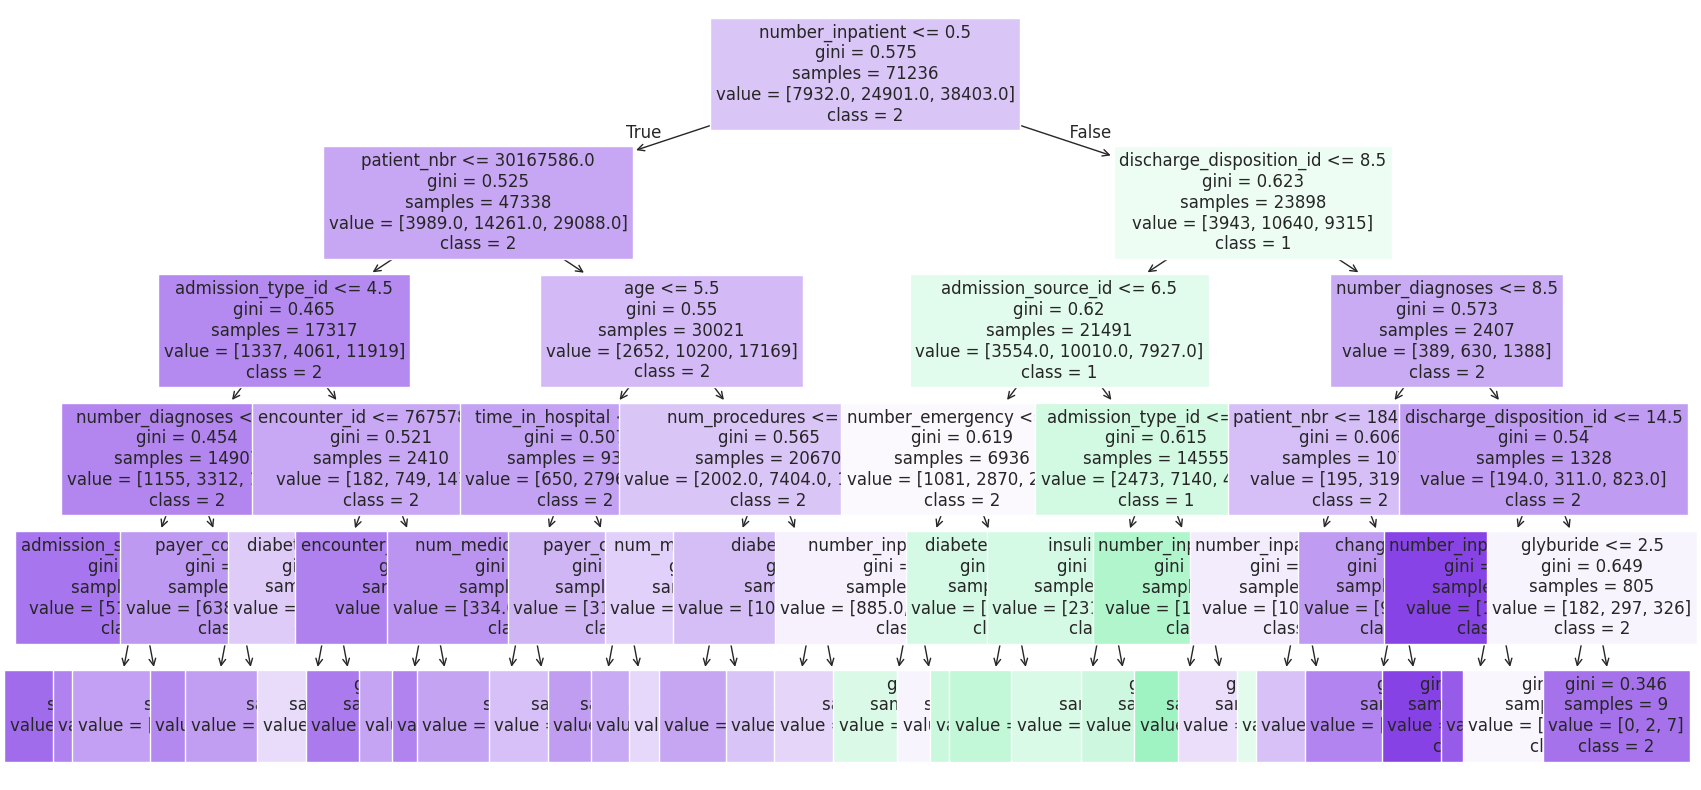

In [20]:
# Построение логического классификатора
max_depth = 5  # Максимальная глубина дерева
max_features = 10  # Максимальное количество признаков
clf = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, random_state=42)
clf.fit(X_train, y_train)

# Визуализация дерева решений
plt.figure(figsize=(20, 10))
plot_tree(
    clf,
    filled=True,
    feature_names=X.columns,
    class_names=[str(label) for label in clf.classes_],
    fontsize=12
)
plt.savefig('decision_tree.png')  # Сохраняем дерево в файл .png
plt.show()


## Шаг 3. Оценка MSE для различных значений max_depth

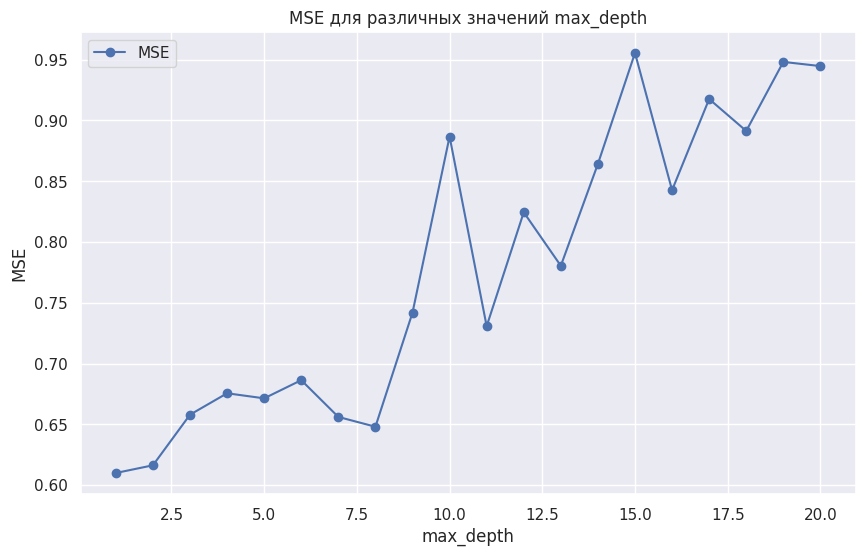

In [21]:
# Импортируем необходимые библиотеки
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Задание параметров
max_features = 10  # Максимальное количество признаков
depth_range = range(1, 21)  # Диапазон значений для max_depth

# Вычисление оценки cross-validation (MSE) для различных значений max_depth
mse_depth = []
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, max_features=max_features, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_depth.append(-scores.mean())

# Построение графика зависимости MSE от max_depth
plt.figure(figsize=(10, 6))
plt.plot(depth_range, mse_depth, marker='o', label='MSE')
plt.title('MSE для различных значений max_depth')
plt.xlabel('max_depth')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()


## Шаг 4. Оценка MSE для различных значений max_features

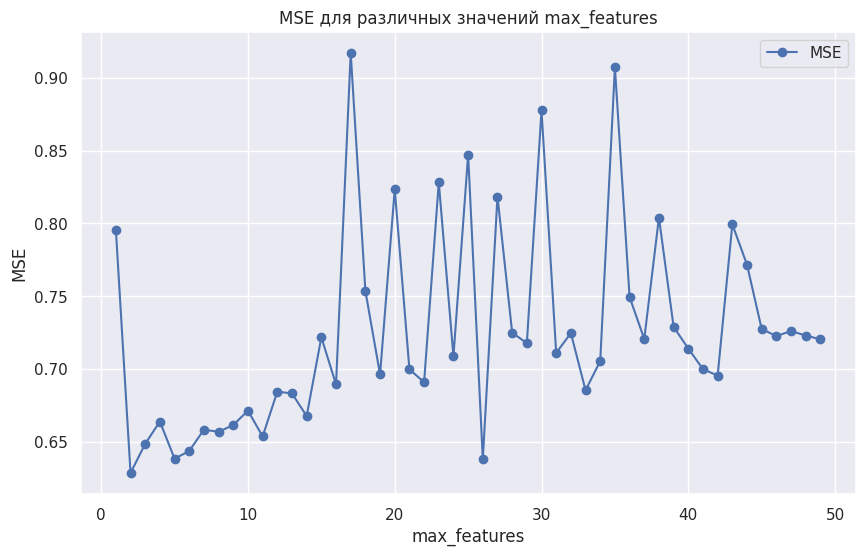

In [22]:
# Импортируем необходимые библиотеки
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Установка параметров
max_depth = 5  # Фиксированная глубина дерева
features_range = range(1, X.shape[1] + 1)  # Диапазон количества признаков от 1 до общего числа
mse_features = []

# Вычисление оценки cross-validation (MSE) для различных значений max_features
for features in features_range:
    clf = DecisionTreeClassifier(max_depth=max_depth, max_features=features, random_state=42)
    scores = cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error')
    mse_features.append(-scores.mean())

# Построение графика зависимости MSE от max_features
plt.figure(figsize=(10, 6))
plt.plot(features_range, mse_features, marker='o', label='MSE')
plt.title('MSE для различных значений max_features')
plt.xlabel('max_features')
plt.ylabel('MSE')
plt.grid(True)
plt.legend()
plt.show()


## Шаг 5. Оптимизация параметров и построение улучшенного дерева


In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Определение диапазонов для параметров max_depth и max_features
param_grid = {
    'max_depth': range(1, 21),  # Глубина дерева от 1 до 20
    'max_features': range(1, X.shape[1] + 1)  # Количество признаков от 1 до общего числа
}

# Поиск оптимальных параметров с помощью GridSearchCV
grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Оптимальные параметры
optimal_max_depth = grid_search.best_params_['max_depth']
optimal_max_features = grid_search.best_params_['max_features']
print(f"Оптимальные значения max_depth: {optimal_max_depth}, max_features: {optimal_max_features}")

# Построение и обучение модели с оптимальными параметрами
clf_optimal = DecisionTreeClassifier(max_depth=optimal_max_depth, max_features=optimal_max_features, random_state=42)
clf_optimal.fit(X_train, y_train)

# Визуализация оптимизированного дерева решений
plt.figure(figsize=(20, 10))
plot_tree(clf_optimal, filled=True, feature_names=X.columns, class_names=clf_optimal.classes_, fontsize=10)
plt.savefig('optimal_decision_tree.png')  # Сохраняем оптимизированное дерево в файл .png
plt.show()


KeyboardInterrupt: 

## Шаг 6. Визуализация решающих границ

In [29]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# Загрузка данных
df = pd.read_csv('diabetic_data.csv', delimiter=',')

# Проверка наличия целевой переменной 'readmitted'
if 'readmitted' not in df.columns:
    raise KeyError("Целевая переменная 'readmitted' отсутствует в данных.")

# Разделение на признаки и целевую переменную
X = df.drop(columns=['readmitted'])  # Все признаки
y = df['readmitted']  # Целевая переменная

# Разделяем данные на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Подготовим GridSearchCV для нахождения оптимальных параметров
param_grid = {
    'max_depth': range(1, 21),
    'max_features': range(1, X.shape[1] + 1)
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Оптимальные параметры
optimal_max_depth = grid_search.best_params_['max_depth']
optimal_max_features = grid_search.best_params_['max_features']
print(f"Оптимальные значения max_depth: {optimal_max_depth}, max_features: {optimal_max_features}")

# Обучение модели с оптимальными параметрами
clf_optimal = DecisionTreeClassifier(max_depth=optimal_max_depth, max_features=optimal_max_features, random_state=42)
clf_optimal.fit(X_train, y_train)

# Визуализация оптимизированного дерева
plt.figure(figsize=(20, 10))
plot_tree(clf_optimal, filled=True, feature_names=X.columns, class_names=['No Readmission', 'Readmitted'], fontsize=12)
plt.savefig('optimal_decision_tree.png')  # Сохраняем оптимизированное дерево в файл .png
plt.show()

# Для визуализации выбираем два признака
X_train_2d = X_train[['num_lab_procedures', 'num_medications']]  # Признаки для построения границ

# Построение решающих границ
h = .02  # шаг сетки для графика
x_min, x_max = X_train_2d['num_lab_procedures'].min() - 1, X_train_2d['num_lab_procedures'].max() + 1
y_min, y_max = X_train_2d['num_medications'].min() - 1, X_train_2d['num_medications'].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Обучение модели на двух признаках с оптимальными параметрами
clf_optimal_2d = DecisionTreeClassifier(max_depth=optimal_max_depth, max_features=optimal_max_features, random_state=42)
clf_optimal_2d.fit(X_train_2d, y_train)

Z = clf_optimal_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Визуализация решающих границ
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)

# Нанесение точек обучающей выборки
scatter = plt.scatter(
    X_train_2d['num_lab_procedures'], X_train_2d['num_medications'],
    c=y_train, edgecolors='k', marker='o', cmap=plt.cm.RdYlBu, label='Training data'
)

# Добавление легенды
class_labels = ['No Readmission', 'Readmitted']  # Пример для вашего датасета
handles, _ = scatter.legend_elements()
plt.legend(
    handles, class_labels, title="Classes", loc="upper right", fontsize=10
)

# Подписи осей и заголовок
plt.title('Решающие границы для двух признаков: num_lab_procedures и num_medications', fontsize=14)
plt.xlabel('num_lab_procedures', fontsize=12)
plt.ylabel('num_medications', fontsize=12)

# Линии сетки для удобства анализа
plt.grid(True, linestyle='--', linewidth=0.5)

# Показ графика
plt.show()


KeyboardInterrupt: 

## Вывод

1. Оптимальные параметры модели: max_features около 15-20 и max_depth около 5-7. При таком количестве признаков достигается минимальное значение MSE, а увеличение глубины свыше 7 приводит к переобучению и росту ошибки.
2. Эти параметры обеспечивают баланс между точностью модели и ее обобщающей способностью.График решающих границ показывает, что команда Blue чаще побеждает при большом количестве убийств и низком уровне смертей, а команда Red — наоборот.
3. Модель четко разделяет области, но ошибки в классификации в некоторых зонах указывают на влияние дополнительных факторов, не учтенных в выбранных признаках.